In [333]:
import pandas as pd

In [334]:
df = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\Prophet\Daily Bike Sharing training.csv")


In [335]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid

In [345]:
# Renaming Variables 2 and 3

df = df.rename(columns = {
    2: 'weather_sit_2',
    3: 'weather_sit_3'
})

In [347]:
# Drop variables that are not needed
df = df.drop(columns = ['instant','season','yr','mnth','weekday','casual','registered'])

In [348]:
# Create a copy of the df with date as index

df_temp = df.set_index('ds').copy()
df_temp = df_temp.asfreq('D')

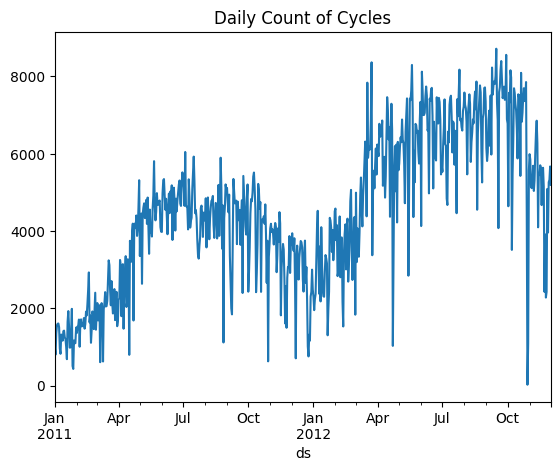

In [349]:
df_temp['y'].plot(title = 'Daily Count of Cycles');

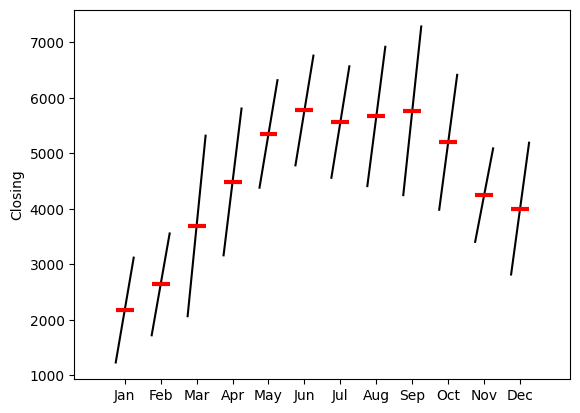

In [350]:
month_plot(df_temp['y'].resample('MS').mean(), ylabel='Closing');

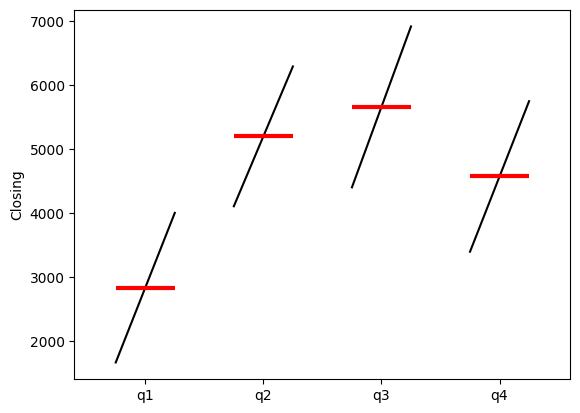

In [351]:
quarter_plot(df_temp['y'].resample('QE').mean(), ylabel='Closing');

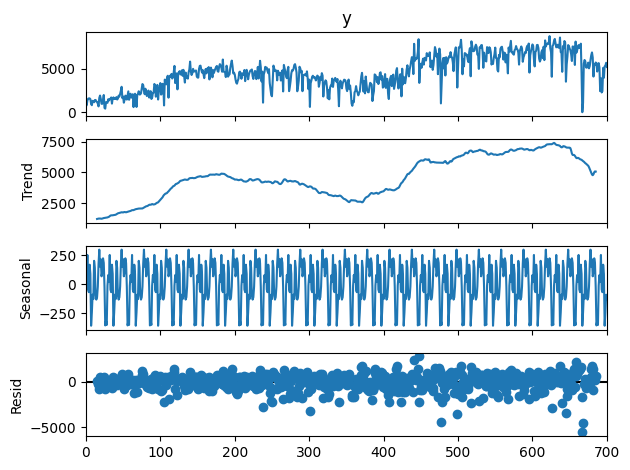

In [352]:
decomposition = seasonal_decompose(df['y'], model = 'add', period = 30)
fig = decomposition.plot()

plt.show()

In [ ]:
to_replace = df.loc[df.ds == '2012-10-28']['y'].iloc[0]

df.loc[df.ds == '2012-10-29','y'] = to_replace
df.loc[df.ds == '2012-10-30','y'] = to_replace

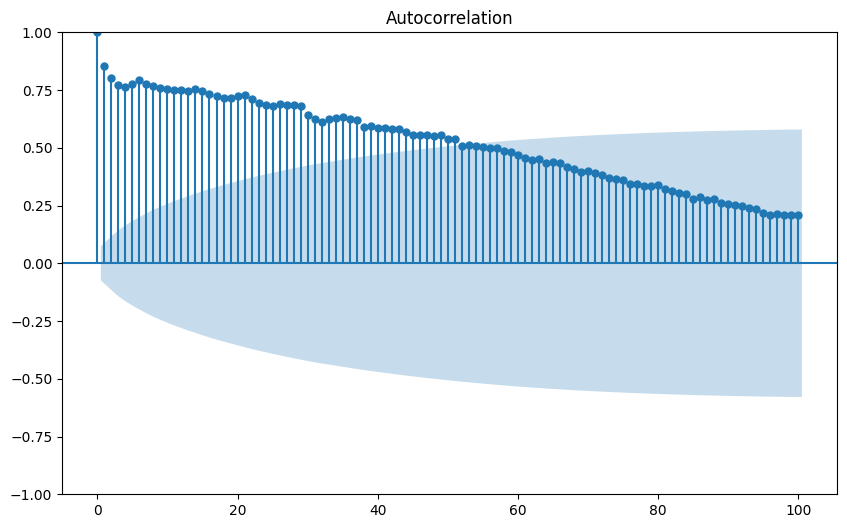

In [354]:
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

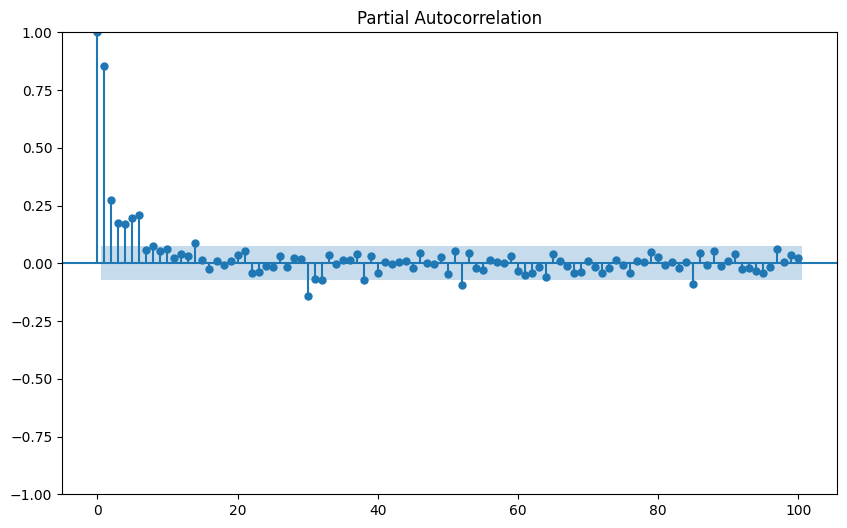

In [355]:
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

In [357]:
# Choco demand increases during valentine day
# The problem is how do we model the demand curve
# Specify 14 with lower and upper window of impact , seek impact for each day between the 11th and 15th
# Set a lower window of -3 it indicates 3 days prior and upper window 1 indicating 3 days after
#


In [359]:
general_holidays = pd.DataFrame(
    {
        'holiday': 'general_holiday',
        'ds': df[df['holiday'] == 1]['ds'],
        'lower_window': -2,
        'upper_window': 2
    }
)

xmas = pd.DataFrame(
    {
        'holiday': 'christmas',
        'ds': pd.to_datetime(['2011-12-24','2012-12-24']),
        'lower_window': -5,
        'upper_window': 3
    }
)



nye = pd.DataFrame(
    {
        'holiday': 'new_year',
        'ds': pd.to_datetime(['2011-12-31','2012-12-31']),
        'lower_window': -3,
        'upper_window': 3
    }
)

easter = pd.DataFrame(
    {
        'holiday': 'easter',
        'ds': pd.to_datetime(['2011-04-24','2012-04-08']),
        'lower_window': -3,
        'upper_window': 3
    }
)


holidays = pd.concat([general_holidays, xmas, nye, easter], axis=0)

Prophet Parameters




*   Seasonality - Yearly, weekly, daily
*   Seasonality_mode - Multiplicative or Additive
*   Holidays - Dataframe with holiday dates
*   seasonality_prior_scale - Strength of seasonality
*   holiday_prior_Scale - Larger values allow to fit larger seasonal fluctuations
* changepoint_prior_scale - does the trend change easily




## Feature Engineering 

In [360]:
# Shift does a positive shift it brings the values down i.e yesterdays values will come to today 
# Creating lagged values for the regressors 
for lag in [1,3,5,7]: 
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag).fillna(0)
    df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag).fillna(0)


In [362]:
# Building a correlation matrix to check the relationship between y and lagged values

columns_to_correlate = ["y"] + [
    f"{var}_lag_{lag}" for var in ["temp", "atemp"] for lag in [1, 3, 5, 7]
]

In [363]:
df[columns_to_correlate].corr()

,y,temp_lag_1,temp_lag_3,temp_lag_5,temp_lag_7,atemp_lag_1,atemp_lag_3,atemp_lag_5,atemp_lag_7
y,1.000000,0.592985,0.589709,0.601263,0.610573,0.589377,0.585123,0.598814,0.606808
temp_lag_1,0.592985,1.000000,0.889413,0.859537,0.862950,0.991594,0.879163,0.845663,0.850095
temp_lag_3,0.589709,0.889413,1.000000,0.891311,0.861902,0.874683,0.991723,0.881357,0.848542
temp_lag_5,0.601263,0.859537,0.891311,1.000000,0.893159,0.847202,0.877018,0.991827,0.883572
temp_lag_7,0.610573,0.862950,0.861902,0.893159,1.000000,0.851851,0.850004,0.879190,0.991945
atemp_lag_1,0.589377,0.991594,0.874683,0.847202,0.851851,1.000000,0.865982,0.834713,0.840164
atemp_lag_3,0.585123,0.879163,0.991723,0.877018,0.850004,0.865982,1.000000,0.868746,0.838110
atemp_lag_5,0.598814,0.845663,0.881357,0.991827,0.879190,0.834713,0.868746,1.000000,0.871402
atemp_lag_7,0.606808,0.850095,0.848542,0.883572,0.991945,0.840164,0.838110,0.871402,1.000000


In [364]:
df = df.drop(columns=[
    f"{var}_lag_{lag}" for var in ["temp", "atemp"] for lag in [3, 5, 7]
])

In [365]:
df

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weather_sit_2,weather_sit_3,temp_lag_1,atemp_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,True,False,0.000000,0.000000
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,True,False,0.344167,0.363625
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,False,False,0.363478,0.353739
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,False,False,0.196364,0.189405
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,False,False,0.200000,0.212122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2012-11-27,0,1,2,0.291667,0.281558,0.786667,0.237562,3959,True,False,0.313333,0.339004
697,2012-11-28,0,1,1,0.296667,0.289762,0.506250,0.210821,5260,False,False,0.291667,0.281558
698,2012-11-29,0,1,1,0.280870,0.298422,0.555652,0.115522,5323,False,False,0.296667,0.289762
699,2012-11-30,0,1,1,0.298333,0.323867,0.649583,0.058471,5668,False,False,0.280870,0.298422


In [366]:
from prophet import Prophet 

Sure, let's break down the parameters used in the Prophet model instantiation you provided.

The Prophet model from Facebook (Meta) is designed for forecasting time series data, especially those with strong seasonalities and trends. It works by decomposing the time series into trend, seasonality, and holiday components.

Here's an explanation of each parameter you've used:

holidays:

Purpose: This parameter allows you to explicitly include the effects of specific holidays or recurring events on your time series.
Type: It expects a Pandas DataFrame with two columns: holiday (name of the holiday, string) and ds (date of the holiday, datetime or date). Optionally, you can also include lower_window and upper_window (integers) to specify the number of days before and after the holiday where its effect is felt.
How it works: Prophet will estimate the impact of each defined holiday on the time series and incorporate it into the forecast. This is particularly useful for events that have a significant, but non-periodic, influence on your data (e.g., Christmas, New Year's Day, specific company events).
In your example: You've passed holidays (presumably a pre-defined DataFrame of holidays) directly.


seasonality_mode:

Purpose: This parameter determines how the seasonal components (e.g., daily, weekly, yearly) interact with the trend.
Type: String.
Possible Values:
'additive' (default): The seasonal effect is added to the trend. This means the magnitude of the seasonality remains constant regardless of the trend's value. For example, if the trend is increasing, the seasonal swings will still be the same absolute size.
'multiplicative': The seasonal effect is multiplied by the trend. This means the magnitude of the seasonality changes proportionally with the trend. If the trend is increasing, the seasonal swings will also increase in magnitude. This is often more appropriate for data where seasonal fluctuations grow with the overall level of the series (e.g., sales data where higher sales mean larger seasonal peaks).
In your example: You've set it to "multiplicative", indicating that you expect your seasonal patterns to scale with the overall magnitude of your time series.


seasonality_prior_scale:

Purpose: This parameter controls the flexibility of the model in fitting the seasonal components. It acts as a regularization parameter.
Type: Float.
Effect:
A larger value (e.g., 10, 20) allows the seasonality to be more flexible and fit the historical data more closely, potentially leading to overfitting if the data is noisy.
A smaller value (e.g., 0.1, 1) makes the seasonality smoother and less flexible, which can help prevent overfitting but might underfit if the true seasonality is complex.
Interpretation: It's essentially the standard deviation of the prior distribution for the seasonal coefficients. A higher value means the model is more confident that the seasonal effects are large.
In your example: You've set it to 10, which is a relatively high value, suggesting you're allowing for significant flexibility in fitting the seasonal patterns.



holidays_prior_scale:

Purpose: Similar to seasonality_prior_scale, this parameter controls the flexibility of the model in fitting the holiday effects.
Type: Float.
Effect:
A larger value allows the model to estimate larger and more pronounced effects for holidays.
A smaller value shrinks the estimated holiday effects towards zero, meaning the model will attribute less impact to holidays.
Interpretation: This is the standard deviation of the prior for the holiday coefficients.
In your example: You've set it to 10, indicating you're allowing for significant impact from the defined holidays.




changepoint_prior_scale:

Purpose: This parameter controls the flexibility of the trend component, specifically how much the trend is allowed to change its rate.
Type: Float.
Effect:
A larger value (e.g., 0.1, 0.5) makes the trend more flexible, allowing for more potential changepoints (points where the trend rate changes) and larger changes in trend. This can lead to a more volatile trend that closely follows the data, potentially overfitting.
A smaller value (e.g., 0.001, 0.01) makes the trend smoother and less flexible, meaning fewer and smaller changepoints. This can help prevent overfitting and result in a more stable trend line, but might underfit if there are true significant changes in the trend that the model can't capture.
Default: The default value is 0.05.
In your example: You've set it to 0.05, which is the default value, suggesting a moderate level of flexibility for the trend.
In summary, when you instantiate the model as:

Python

model = Prophet(
    holidays=holidays,
    seasonality_mode="multiplicative",
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05,
)
You are telling Prophet to:

Consider the specific holidays you've provided.
Assume that seasonal effects will scale proportionally with the overall trend (multiplicative).
Allow for significant flexibility in fitting both seasonal and holiday effects (seasonality_prior_scale=10, holidays_prior_scale=10). This means the model will try to capture prominent seasonal and holiday patterns.
Use the default level of flexibility for detecting and fitting trend changes (changepoint_prior_scale=0.05).
After defining the model with these parameters, you then call model.fit(df). This step is where Prophet actually learns the trend, seasonality, and holiday components from your historical data (df). The df DataFrame should have at least two columns: ds (datestamp, in datetime format) and y (the measurement to be forecasted, numeric).

In [367]:
model = Prophet(
    holidays=holidays,
    seasonality_mode="multiplicative",
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05,
)

model.add_regressor('workingday')
model.add_regressor('temp')
model.add_regressor('atemp')
model.add_regressor('hum')
model.add_regressor('windspeed')
model.add_regressor('weather_sit_2')
model.add_regressor('weather_sit_3')
model.add_regressor('temp_lag_1')
model.add_regressor('atemp_lag_1')

model.fit(df)


21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] done processing


In [368]:
# Regressor Coefficients 
from prophet.utilities import regressor_coefficients 

regressor_coefficients_dict = regressor_coefficients(model).to_dict(orient='records')


In [369]:
def interpret_prophet_coefficients(coeff_table): 
    interpretations = [] 
    for row in regressor_coefficients_dict: 
        name = row['regressor'] 
        mode = row['regressor_mode'] 
        center = float(row['center']) 
        coef = float(row['coef']) 

        if mode == 'additive': 

            if coef > 0: 
                effect = f"increases the forecast by {coef:.3f} units" 
            elif coef < 0: 
                effect = f"decreases the forecast by {abs(coef):.3f} units" 
            else: 
                effect = "has no effect on the forecast" 
            interp = (
                f"When {name} increases by 1 unit above centered value "
                f"({center:.3f}), it {effect} (additive mode)"
            )
            interpretations.append(interp)
        elif mode == 'multiplicative': 
            percent_change = coef * 100 

            if coef > 0: 
                effect = f"increases the forecast by approximately {percent_change:.2f}%" 
            elif coef < 0: 
                effect = f"decrease the forecast by approximately {abs(percent_change):.2f}%"
            else: 
                effect = "has no effect on the forecast" 
            interp = (
                f"When {name} increases by 1 unit above centered value "
                f"({center:.3f}), it {effect} (multiplicative mode)"
            )
            interpretations.append(interp)
    return interpretations 
    


In [370]:
interpret_prophet_coefficients(regressor_coefficients_dict)

['When workingday increases by 1 unit above centered value (0.000), it increases the forecast by approximately 39.54% (multiplicative mode)',
 'When temp increases by 1 unit above centered value (0.503), it increases the forecast by approximately 80.51% (multiplicative mode)',
 'When atemp increases by 1 unit above centered value (0.481), it increases the forecast by approximately 86.36% (multiplicative mode)',
 'When hum increases by 1 unit above centered value (0.626), it decrease the forecast by approximately 31.31% (multiplicative mode)',
 'When windspeed increases by 1 unit above centered value (0.191), it decrease the forecast by approximately 43.64% (multiplicative mode)',
 'When weather_sit_2 increases by 1 unit above centered value (0.000), it decrease the forecast by approximately 9.79% (multiplicative mode)',
 'When weather_sit_3 increases by 1 unit above centered value (0.000), it decrease the forecast by approximately 48.25% (multiplicative mode)',
 'When temp_lag_1 increa

In [371]:
# Number of days present in the dataset 
df.shape[0] - 180 

521

In [372]:
from prophet.diagnostics import cross_validation 
df_cv = cross_validation(model=model,period='15 days', initial= '521 days', horizon='30 days', parallel='processes')

In [373]:
551 - 522

29

Purpose of cross_validation
Prophet's cross_validation is used to evaluate the forecasting performance of a model by simulating how it would perform on historical data. It does this by splitting the time series into training and validation sets multiple times and calculating forecast errors.

This technique is called "rolling-origin" cross-validation (also known as time-series split).

🔍 Parameters Explained
model=model
This is your trained Prophet model that you want to evaluate.

initial='521 days'
The initial training period. Prophet will start by training on the first 521 days of data.

horizon='30 days'
The forecasting horizon. After each training window, Prophet forecasts 30 days into the future, which is then compared to the actual data for accuracy.

period='15 days'
This is how much Prophet shifts forward the cutoff point each time before making the next forecast. So, it will make a forecast every 15 days using the latest available data up to that point.

parallel='processes'
This enables parallel processing using multiple CPU cores to speed up the cross-validation computation.

🔁 How It Works (Example Flow)
Let's assume you have 600 days of data. Here's a simplified explanation:

First training window: Use the first 521 days to fit the model, then forecast the next 30 days.

First evaluation: Compare the forecast with the actual data from days 522 to 551.

Next step: Move the cutoff point forward by 15 days (now it's day 536), train on data up to that point, and forecast the next 30 days.

Repeat: This process continues until there’s no more data left to validate against.

Each of these steps produces a forecast and compares it with the actual values for evaluation.



In [374]:
from prophet.diagnostics import performance_metrics 
rmse = performance_metrics(df_cv)['rmse'].mean().round(0) 
mape = performance_metrics(df_cv)['mape'].mean().round(0)

performance_metrics(df_cv).mean()




horizon     16 days 12:00:00
mse           1889834.620115
rmse             1357.182335
mae              1084.907616
mape                0.183584
mdape               0.135086
smape               0.167952
coverage            0.464286
dtype: object

Column Descriptions
horizon
How far ahead the forecast was made (e.g., 1 day, 2 days, ... up to 30 days). Prophet automatically evaluates each step within the forecast horizon.

mse – Mean Squared Error
Average of the squared differences between predicted (yhat) and actual (y).

rmse – Root Mean Squared Error
Square root of MSE. Gives errors in the original unit (e.g., if you're forecasting sales, it's in sales units).

mae – Mean Absolute Error
Average of the absolute errors between predicted and actual.

mape – Mean Absolute Percentage Error
Average absolute error as a percentage of the actual value. Good for understanding relative error.
⚠️ Sensitive to zeros in y.

mdape – Median Absolute Percentage Error
Median version of MAPE — less affected by outliers.

smape – Symmetric Mean Absolute Percentage Error
A variation of MAPE that treats over- and under-predictions more symmetrically.

coverage
Fraction of actual values that fell within the forecast uncertainty interval (yhat_lower to yhat_upper). Ideally close to the confidence level (e.g., 0.80 for 80%).



c:\Work\MLOps\flask_env\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Work\MLOps\flask_env\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


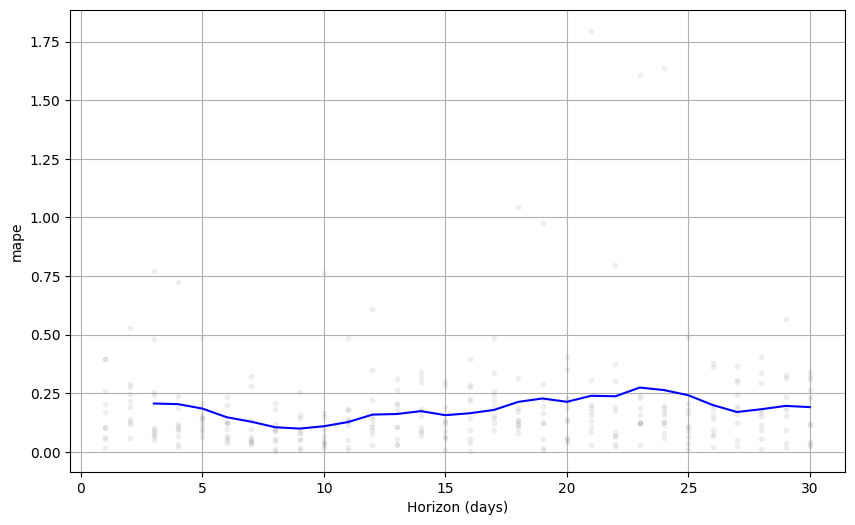

In [375]:
from prophet.plot import plot_cross_validation_metric 


plot_cross_validation_metric(df_cv, metric='mape');

In [376]:
# Understand how to interpret the plot from fb prophet 

In [377]:
## Exploring the error 

In [378]:
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']

df_cv['deviation_pct'] = ((df_cv['yhat'] / df_cv['y']) - 1) * 100 

df_cv['deviation_pct']

0      39.620223
1      52.700784
2      47.967793
3       9.823612
4      20.152268
         ...    
295    37.976337
296    30.588257
297    33.754733
298    31.533410
299    26.329777
Name: deviation_pct, Length: 300, dtype: float64

In [379]:
# Days with highest deviation 
df_cv.sort_values(by='deviation', ascending=False).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_pct
17,2012-07-07,9898.749128,9150.907089,10683.126230,4840,2012-06-19,5058.749128,104.519610
18,2012-07-08,9237.606012,8478.264326,10049.600038,4672,2012-06-19,4565.606012,97.722731
290,2012-11-22,6780.994694,6013.704179,7675.976227,2425,2012-11-01,4355.994694,179.628647
9,2012-06-29,9618.374698,8793.125465,10362.526808,5463,2012-06-19,4155.374698,76.063970
293,2012-11-25,6394.422837,5511.772594,7250.664410,2424,2012-11-01,3970.422837,163.796322
32,2012-07-07,8567.349365,7756.836906,9423.913193,4840,2012-07-04,3727.349365,77.011351
292,2012-11-24,5933.166974,5063.822741,6736.787665,2277,2012-11-01,3656.166974,160.569476
33,2012-07-08,8045.782383,7236.521002,8875.469170,4672,2012-07-04,3373.782383,72.212808
11,2012-07-01,8901.877019,8134.847427,9670.870884,5531,2012-06-19,3370.877019,60.945164
28,2012-07-18,8941.584536,8132.207561,9715.961217,5713,2012-06-19,3228.584536,56.512945


In [380]:
# Days with lowest deviation 
df_cv.sort_values(by='deviation', ascending=True).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_pct
176,2012-09-29,5991.534370,5074.706204,6821.542514,8555,2012-09-02,-2563.465630,-29.964531
147,2012-09-15,6150.650055,5221.000056,7005.447907,8714,2012-08-18,-2563.349945,-29.416456
141,2012-09-09,5739.678010,4885.893876,6646.202085,8227,2012-08-18,-2487.321990,-30.233645
89,2012-08-18,5427.265561,4579.978860,6283.799965,7865,2012-07-19,-2437.734439,-30.994716
170,2012-09-23,5490.689881,4704.741387,6390.197181,7907,2012-09-02,-2416.310119,-30.559126
104,2012-08-18,5507.330351,4624.872621,6362.445504,7865,2012-08-03,-2357.669649,-29.976728
88,2012-08-17,4797.528306,3871.691776,5664.245368,7148,2012-07-19,-2350.471694,-32.882928
156,2012-09-09,5924.040016,5059.620981,6772.591591,8227,2012-09-02,-2302.959984,-27.992707
162,2012-09-15,6416.990348,5454.788635,7217.459427,8714,2012-09-02,-2297.009652,-26.359991
103,2012-08-17,4866.392496,4035.933383,5697.563336,7148,2012-08-03,-2281.607504,-31.919523


In [381]:
# Days with highest deviation 

df_cv.sort_values(by='deviation_pct', ascending=False).head(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation,deviation_pct
290,2012-11-22,6780.994694,6013.704179,7675.976227,2425,2012-11-01,4355.994694,179.628647
293,2012-11-25,6394.422837,5511.772594,7250.664410,2424,2012-11-01,3970.422837,163.796322
292,2012-11-24,5933.166974,5063.822741,6736.787665,2277,2012-11-01,3656.166974,160.569476
17,2012-07-07,9898.749128,9150.907089,10683.126230,4840,2012-06-19,5058.749128,104.519610
18,2012-07-08,9237.606012,8478.264326,10049.600038,4672,2012-06-19,4565.606012,97.722731
291,2012-11-23,7032.354049,6132.738059,7948.161874,3910,2012-11-01,3122.354049,79.855602
32,2012-07-07,8567.349365,7756.836906,9423.913193,4840,2012-07-04,3727.349365,77.011351
9,2012-06-29,9618.374698,8793.125465,10362.526808,5463,2012-06-19,4155.374698,76.063970
33,2012-07-08,8045.782383,7236.521002,8875.469170,4672,2012-07-04,3373.782383,72.212808
11,2012-07-01,8901.877019,8134.847427,9670.870884,5531,2012-06-19,3370.877019,60.945164


In [ ]:
# Define the parameter grid to search
param_grid = {
    'changepoint_prior_scale': [0.05, 0.5],
    'seasonality_prior_scale': [10, 20],
    'holidays_prior_scale': [10, 20],
    'seasonality_mode' : ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = list(ParameterGrid(param_grid))
all_params


In [385]:
# Placeholder for storing the results
tuning_results = []

# Build a pipeline for the Parameter Tuning
for params in all_params:

  # build the model
  m = Prophet(
      yearly_seasonality=True,
      weekly_seasonality= True,
      holidays = holidays,
      **params)
  m.add_regressor("workingday")
  m.add_regressor("temp")
  m.add_regressor("atemp")
  m.add_regressor("hum")
  m.add_regressor("windspeed")
  m.add_regressor("weather_sit_2")
  m.add_regressor("weather_sit_3")
  m.add_regressor("temp_lag_1")
  m.fit(df)

  # Cross-Validation
  df_cv = cross_validation(model = m,
                          period = '15 days',
                          initial = '521 days',
                          horizon = '30 days',
                          parallel ='processes')


  # Compute and Store the Error
  rmse = performance_metrics(df_cv)['rmse'].mean()
  tuning_results.append(rmse)

21:59:25 - cmdstanpy - INFO - Chain [1] start processing
21:59:25 - cmdstanpy - INFO - Chain [1] done processing
21:59:28 - cmdstanpy - INFO - Chain [1] start processing
21:59:28 - cmdstanpy - INFO - Chain [1] done processing
21:59:30 - cmdstanpy - INFO - Chain [1] start processing
21:59:31 - cmdstanpy - INFO - Chain [1] done processing
21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing
21:59:36 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing
21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:38 - cmdstanpy - INFO - Chain [1] done processing
21:59:41 - cmdstanpy - INFO - Chain [1] start processing
21:59:41 - cmdstanpy - INFO - Chain [1] done processing
21:59:43 - cmdstanpy - INFO - Chain [1] start processing
21:59:44 - cmdstanpy - INFO - Chain [1] done processing
21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1]

In [386]:
# Parameter Tuning outcome
outcome = pd.DataFrame(all_params)
outcome['tuning_results'] = tuning_results
outcome

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
0,0.05,10,additive,10,982.187235
1,0.05,10,additive,20,983.274072
2,0.05,10,multiplicative,10,1252.577900
3,0.05,10,multiplicative,20,1255.809362
4,0.05,20,additive,10,982.360538
5,0.05,20,additive,20,983.249010
6,0.05,20,multiplicative,10,1257.768137
7,0.05,20,multiplicative,20,1258.965007
8,0.50,10,additive,10,1160.791019
9,0.50,10,additive,20,1154.803026


In [387]:
# Fetch the best params
best_params = all_params[tuning_results.index(min(tuning_results))]

In [388]:
best_params

{'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 10,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10}

In [404]:
df_train = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\Prophet\Daily Bike Sharing training.csv")

df_future = pd.read_csv(r"C:\Users\siddharth\Desktop\Python-Time-Series-Forecasting\Python - Time Series Forecasting\Modern Time Series Forecasting Techniques\Prophet\Daily Bike Sharing future.csv")

df = pd.concat([df_train, df_future])

df = df.reset_index(drop=True) 


df = df.rename(columns = {
    'cnt':'y',
    'dteday':'ds'
})


df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")

weather_situation = pd.get_dummies(df['weathersit'], drop_first=True)


df = pd.concat([df, weather_situation], axis = 1)


# Renaming Variables 2 and 3

df = df.rename(columns = {
    2: 'weather_sit_2',
    3: 'weather_sit_3'
})

# Drop variables that are not needed
df = df.drop(columns = ['instant','season','yr','mnth','weekday','casual','registered'])



to_replace = df.loc[df.ds == '2012-10-28']['y'].iloc[0]

df.loc[df.ds == '2012-10-29','y'] = to_replace
df.loc[df.ds == '2012-10-30','y'] = to_replace



general_holidays = pd.DataFrame(
    {
        'holiday': 'general_holiday',
        'ds': df[df['holiday'] == 1]['ds'],
        'lower_window': -2,
        'upper_window': 2
    }
)

xmas = pd.DataFrame(
    {
        'holiday': 'christmas',
        'ds': pd.to_datetime(['2011-12-24','2012-12-24']),
        'lower_window': -5,
        'upper_window': 3
    }
)



nye = pd.DataFrame(
    {
        'holiday': 'new_year',
        'ds': pd.to_datetime(['2011-12-31','2012-12-31']),
        'lower_window': -3,
        'upper_window': 3
    }
)

easter = pd.DataFrame(
    {
        'holiday': 'easter',
        'ds': pd.to_datetime(['2011-04-24','2012-04-08']),
        'lower_window': -3,
        'upper_window': 3
    }
)


holidays = pd.concat([general_holidays, xmas, nye, easter], axis=0)

In [405]:
# Shift does a positive shift it brings the values down i.e yesterdays values will come to today 
# Creating lagged values for the regressors 
for lag in [1,3,5,7]: 
    df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
    df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag)


In [406]:
df = df.drop(columns=[
    f"{var}_lag_{lag}" for var in ["temp", "atemp"] for lag in [3, 5, 7]
])

In [407]:


train = df.iloc[:-30] 
train = train.dropna()

In [409]:
model = Prophet(holidays=holidays, **best_params)

model.add_regressor("workingday")
model.add_regressor("temp")
model.add_regressor("atemp")
model.add_regressor("hum")
model.add_regressor("windspeed")
model.add_regressor("weather_sit_2")
model.add_regressor("weather_sit_3")
model.add_regressor("temp_lag_1")
model.add_regressor("atemp_lag_1")

model.fit(train)

22:33:52 - cmdstanpy - INFO - Chain [1] start processing
22:33:52 - cmdstanpy - INFO - Chain [1] done processing


In [412]:
future = model.make_future_dataframe(periods=30)

In [414]:
future_regressors = df.drop(columns=['ds','y']).dropna().reset_index(drop=True)

In [415]:
future_regressors

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,weather_sit_2,weather_sit_3,temp_lag_1,atemp_lag_1
0,0,0,2,0.363478,0.353739,0.696087,0.248539,True,False,0.344167,0.363625
1,0,1,1,0.196364,0.189405,0.437273,0.248309,False,False,0.363478,0.353739
2,0,1,1,0.200000,0.212122,0.590435,0.160296,False,False,0.196364,0.189405
3,0,1,1,0.226957,0.229270,0.436957,0.186900,False,False,0.200000,0.212122
4,0,1,1,0.204348,0.233209,0.518261,0.089565,False,False,0.226957,0.229270
...,...,...,...,...,...,...,...,...,...,...,...
725,0,1,2,0.254167,0.226642,0.652917,0.350133,True,False,0.243333,0.220333
726,0,1,2,0.253333,0.255046,0.590000,0.155471,True,False,0.254167,0.226642
727,0,0,2,0.253333,0.242400,0.752917,0.124383,True,False,0.253333,0.255046
728,0,0,1,0.255833,0.231700,0.483333,0.350754,False,False,0.253333,0.242400


In [417]:
future = pd.concat([future, future_regressors], axis=1)

In [418]:
future

,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,weather_sit_2,weather_sit_3,temp_lag_1,atemp_lag_1
0,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,True,False,0.344167,0.363625
1,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,False,False,0.363478,0.353739
2,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,False,False,0.196364,0.189405
3,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,False,False,0.200000,0.212122
4,2011-01-06,0,1,1,0.204348,0.233209,0.518261,0.089565,False,False,0.226957,0.229270
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2012-12-27,0,1,2,0.254167,0.226642,0.652917,0.350133,True,False,0.243333,0.220333
726,2012-12-28,0,1,2,0.253333,0.255046,0.590000,0.155471,True,False,0.254167,0.226642
727,2012-12-29,0,0,2,0.253333,0.242400,0.752917,0.124383,True,False,0.253333,0.255046
728,2012-12-30,0,0,1,0.255833,0.231700,0.483333,0.350754,False,False,0.253333,0.242400


In [419]:
forecast = model.predict(future)

In [420]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,atemp,...,windspeed,windspeed_lower,windspeed_upper,workingday,workingday_lower,workingday_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-02,2418.518416,461.619712,2446.018994,2418.518416,2418.518416,-947.656550,-947.656550,-947.656550,-351.742392,...,-114.688839,-114.688839,-114.688839,0.000000,0.000000,0.000000,0.0,0.0,0.0,1470.861866
1,2011-01-03,2423.344139,114.977452,2229.644844,2423.344139,2423.344139,-1231.138859,-1231.138859,-1231.138859,-805.899663,...,-114.233737,-114.233737,-114.233737,720.510119,720.510119,720.510119,0.0,0.0,0.0,1192.205280
2,2011-01-04,2428.169863,627.946690,2611.702843,2428.169863,2428.169863,-791.791171,-791.791171,-791.791171,-743.118432,...,59.917862,59.917862,59.917862,720.510119,720.510119,720.510119,0.0,0.0,0.0,1636.378691
3,2011-01-05,2432.995586,877.461315,2936.878612,2432.995586,2432.995586,-516.866251,-516.866251,-516.866251,-695.727820,...,7.276444,7.276444,7.276444,720.510119,720.510119,720.510119,0.0,0.0,0.0,1916.129335
4,2011-01-06,2437.821310,873.327254,2951.018254,2437.821310,2437.821310,-549.979961,-549.979961,-549.979961,-684.841908,...,199.873118,199.873118,199.873118,720.510119,720.510119,720.510119,0.0,0.0,0.0,1887.841349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2012-12-27,6423.434752,1740.323131,3737.699018,6419.978753,6426.374260,-3673.582431,-3673.582431,-3673.582431,-702.990622,...,-315.713205,-315.713205,-315.713205,720.510119,720.510119,720.510119,0.0,0.0,0.0,2749.852321
726,2012-12-28,6428.859490,3495.163492,5567.126261,6425.143679,6431.974709,-1836.775049,-1836.775049,-1836.775049,-624.492666,...,69.465105,69.465105,69.465105,720.510119,720.510119,720.510119,0.0,0.0,0.0,4592.084441
727,2012-12-29,6434.284228,3139.488307,5219.606653,6430.289285,6437.571951,-2252.977585,-2252.977585,-2252.977585,-659.441446,...,130.979028,130.979028,130.979028,0.000000,0.000000,0.000000,0.0,0.0,0.0,4181.306643
728,2012-12-30,6439.708965,3098.139438,5118.007887,6435.429935,6443.174480,-2340.856764,-2340.856764,-2340.856764,-689.012215,...,-316.941980,-316.941980,-316.941980,0.000000,0.000000,0.000000,0.0,0.0,0.0,4098.852201


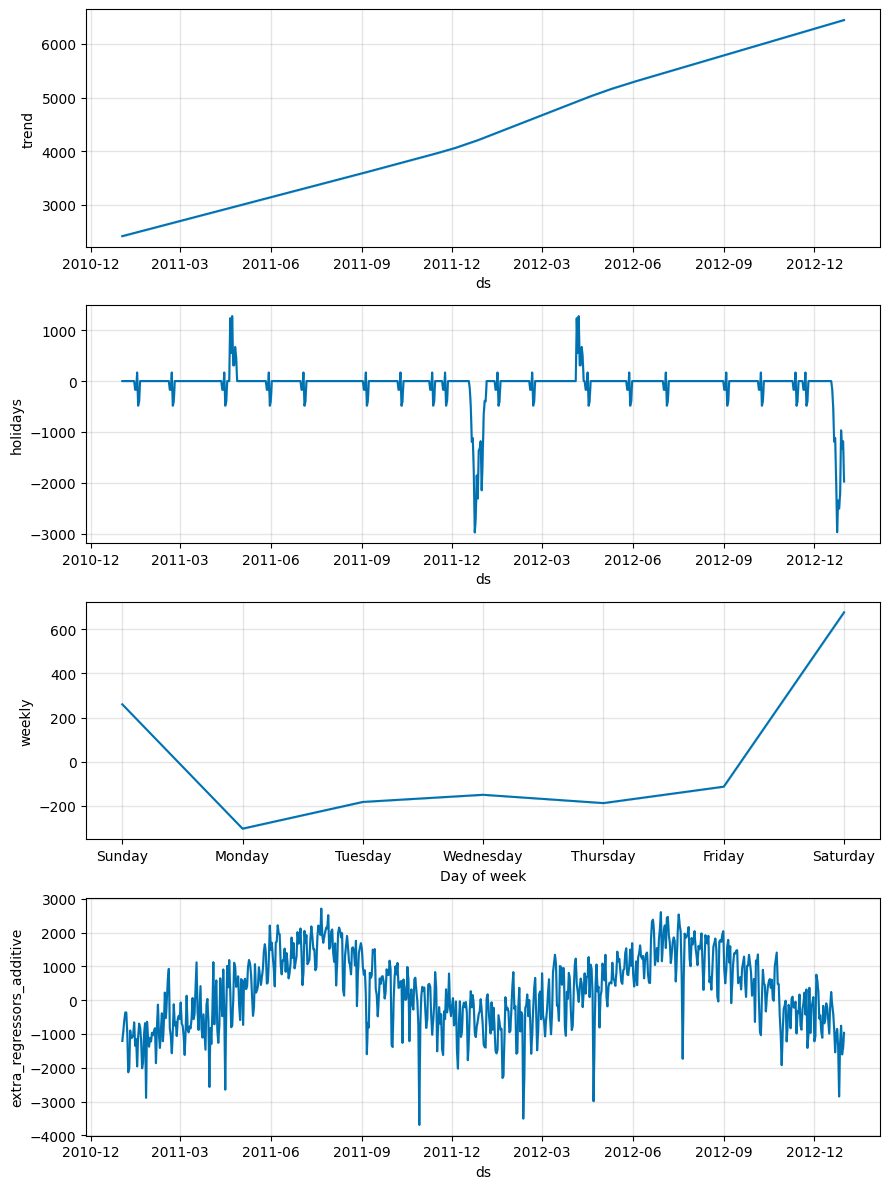

In [422]:
model.plot_components(forecast);

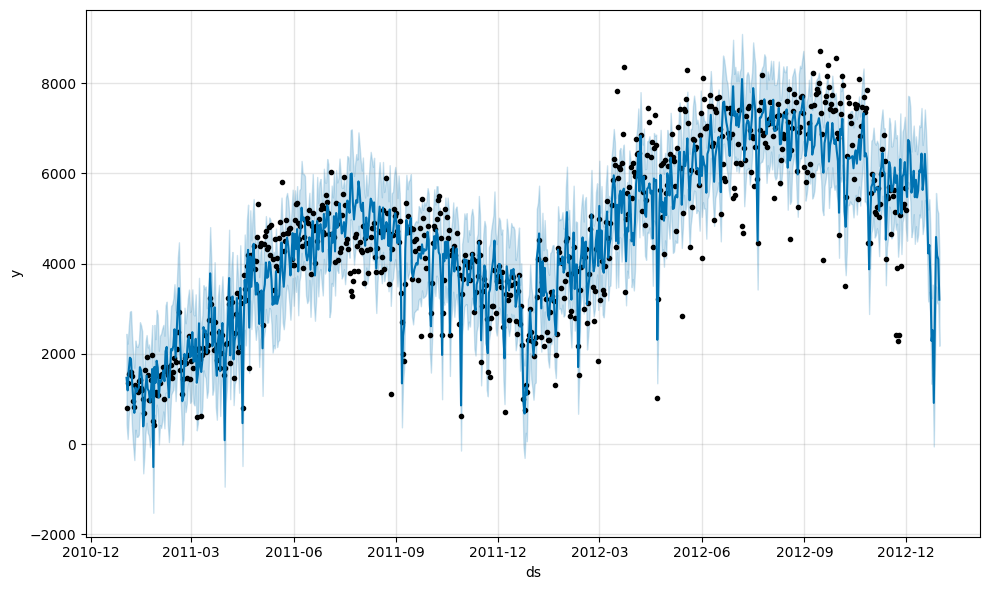

In [424]:
model.plot(forecast);

In [425]:
from prophet.plot import plot_plotly 


fig = plot_plotly(model, forecast) 


In [426]:
fig

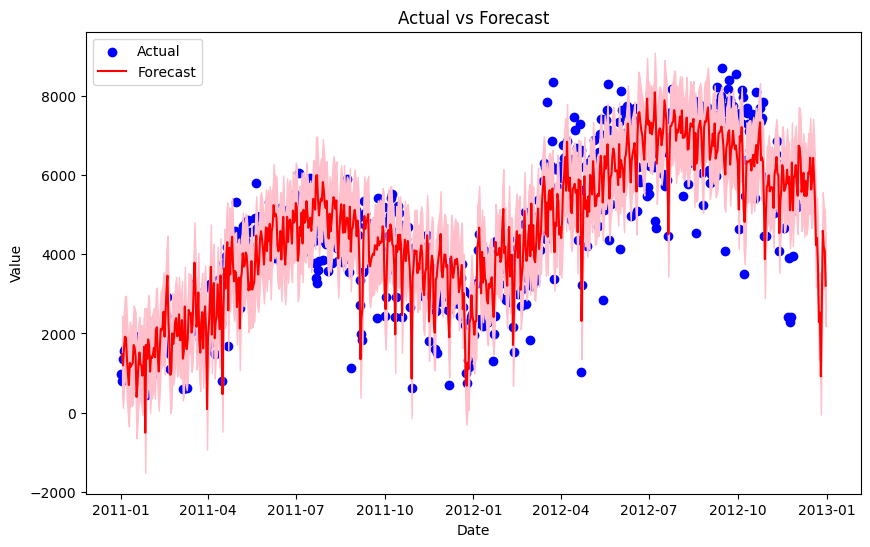

In [435]:
# Visualize time series plot
plt.figure(figsize=(10, 6))

plt.scatter(df['ds'], df['y'], label = 'Actual', color = 'blue')
plt.plot(forecast['ds'], forecast['yhat'], label = 'Forecast', color = 'red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color = 'pink', alpha = 1)

plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()